In [3]:
# 6-65 필요한 라이브러리 호출
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
# 네이드 튜플 - 파이썬의 자료형 (튜플의 성질 + 키 값으로 데이터에 접근 가능)
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# 6-66 이미지 데이터 전처리
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]), # 훈련 이미지 데이터에 대한 전처리
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]) # 검증과 테스트 이미지 데이터에 대한 전처리
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [5]:
# 6-67 변수에 대한 값 정의
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [2]:
import zipfile
import os

with zipfile.ZipFile('dogs-vs-cats.zip', 'r') as zip_ref:
    zip_ref.extractall('dogs-vs-cats')

print("압축 해제 완료")

print(os.listdir('dogs-vs-cats'))

압축 해제 완료
['Cat', 'Dog']


In [6]:
# 6-68 훈련과 테스트 데이터셋 불러오기
cat_directory = 'dogs-vs-cats/Cat/'
dog_directory = 'dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

In [28]:
# 6-69 데이터셋을 훈련, 검증, 테스트 용도로 분리
random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

train_images_filepaths = train_images_filepaths[:50]   # 훈련 50장만 사용
val_images_filepaths = val_images_filepaths[:10]       # 검증 10장만 사용
test_images_filepaths = test_images_filepaths[:5]      # 테스트 5장만 사용

print("데이터 축소 후:", len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10
데이터 축소 후: 50 10 5


In [29]:
# 6-70 이미지에 대한 레이블 구분
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

In [30]:
# 6-71 이미지 데이터셋 정의
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [31]:
# 6-72 데이터셋의 데이터를 메모리로 불러오기
train_iterator  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_iterator = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_iterator, 'val': valid_iterator}

batch_iterator = iter(train_iterator)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 0, 1, 1, 0])


In [32]:
# 6-73 기본 블록 정의
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False) # 3x3 합서ㅇ곱층
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = 1, padding = 1, bias = False) # 3x3 합성곱층
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace = True)

        if downsample: # downsample 적용
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        self.downsample = downsample

    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i # 아이덴티티 매핑 적용 (=스킵 연결)
        x = self.relu(x)

        return x

down sample
- 입력 데이터의 크기와 네트워크 통과 후 출력 데이터의 크기가 다를 경우 사용
- 합성곱층에 스트라이드 적용
- conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)

아이덴티티 매핑 = 숏컷 = 스킵 연결
- x에 conv1, bn1, relu, conv2, bn2 값이 더해지다가 초기의 x가 다시 더해지는 것

In [33]:
# 6-74 병목 블록 정의
class Bottleneck(nn.Module):
    expansion = 4 # ResNet에서 병목 블록을 정의하기 위한 하이퍼파라미터

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, bias = False) # 1x1 합성곱층
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False) # 3x3 합성곱층
        self.bn2 = nn.BatchNorm2d(out_channels)
        # 1x1 합성곱층, 또한 다음 계층의 입력 채널 수와 일치하도록 self.expansion out_channels를 함
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                              stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        self.downsample = downsample

    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

기본 블록과 병목 블록 차이
- 기본 블록: 3x3 합성곱층 2개
- 병목 블록: 1x1 합성곱층, 3x3 합성곱층, 1x1 합성곱층

기본 블록 -> 병목 블록 변경 이유
- 계층을 더 깊게 쌓으며 계산에 대한 비용 줄일 수 있음
- 계층이 많아짐 -> 활성화 함수 더 많이 포함 -> 비선형성 처리 가능
- 다양한 입력 데이터에 대한 처리 가능

=> 아이덴티티 매핑과 병목 블록으로 ResNet 네트워크에 더 깊은 계층을 쌓을 수 있게 된것

In [34]:
# 6-75 ResNet 모델 네트워크
class ResNet(nn.Module):
    def __init__(self, config, output_dim, zero_init_residual=False):
        super().__init__()

        block, n_blocks, channels = config # ResNet을 호출할 때 넘겨준 config 값들을 block, n_blocks, channels에 저장
        self.in_channels = channels[0]
        assert len(n_blocks) == len(channels) == 4  # 블록 크기 = 채널 크기 = 4

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

        # 각 레지듀얼 분기에 있는 마지막 BN을 0으로 초기화
        # 다음 레지듀얼 분기를 0에서 시작할 수 있도록
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def get_resnet_layer(self, block, n_blocks, channels, stride = 1): # 블록을 추가하기 위한 함수
        layers = []
        if self.in_channels != block.expansion * channels:
          # in_channels와 block.expansion*channels가 다르면 downsample 적용
            downsample = True
        else:
            downsample = False

        # 계층 추가할 때 in_channels, channels, stride 뿐만 아니라 다운 샘플링 적용 유무도 함께 전달
        layers.append(block(self.in_channels, channels, stride, downsample))

        for i in range(1, n_blocks): # n_blocks 만큼 계층 추가
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        return x, h

In [35]:
# 6-76 ResNetConfig 정의
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [36]:
# 6-77 기본 블록을 사용하여 ResNetConfig 정의
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

In [37]:
# 6-78 병목 블록을 사용하여 ResNetConfig 정의
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [38]:
# 6-79 사전 훈련된 ResNet 모델 사용
# 사전 훈련된 ResNet 모델 사용을 위해서는 pretrained=True로 설정
pretrained_model = models.resnet50(pretrained = True)

In [39]:
# 6-80 사전 훈련된 ResNet 네트워크 확인
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [40]:
# 6-81 ResNet50 Config를 사용한 ResNet 모델 사용
OUTPUT_DIM = 2
model = ResNet(resnet50_config, OUTPUT_DIM)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [41]:
# 6-82 옵티마이저와 손실 함수 정의
# lr = 1e-7은 1*10의 -7승 의미
optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [42]:
# 6-83 모델 학습 정확도 측정 함수 정의
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1) # torch.argmax와 같은 효과
        top_pred = top_pred.t() # 차원 0과 1을 전치하겠다
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred)) # 텐서 비교 함수
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        # 이미지의 정확한 레이블 부여를 위해 사용. (첫번째 레이블이 아닌 정확한 레이블 부여를 위해 사용)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [43]:
# 6-84 모델 학습 함수 정의
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)

        loss = criterion(y_pred[0], y)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item() # 모델이 첫 번째로 예측한 레이블이 붙여짐
        epoch_acc_5 += acc_5.item() # 이미지에 정확한 레이블이 붙여질 것이기 때문에 정확도가 100%

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [44]:
# 6-85 모델 평가 함수 정의
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred[0], y)
            acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [45]:
# 6-86 모델 학습 시간 측정 함수 정의
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [46]:
# 6-87 모델 학습
best_valid_loss = float('inf')
EPOCHS = 1

for epoch in range(EPOCHS):
    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'ResNet-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 0m 36s
	Train Loss: 0.697 | Train Acc @1:  42.53% | Train Acc @5: 100.00%
	Valid Loss: 0.692 | Valid Acc @1:  60.00% | Valid Acc @5: 100.00%


In [47]:
# 6-88 테스트 데이터셋을 이용한 모델 예측
import pandas as pd
id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in test_images_filepaths:
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs[0], dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('ReNet.csv', index=False)
res.head(10)

,id,label
0,125,0.503747
1,138,0.503974
2,18,0.503660
3,187,0.504610
4,207,0.504170


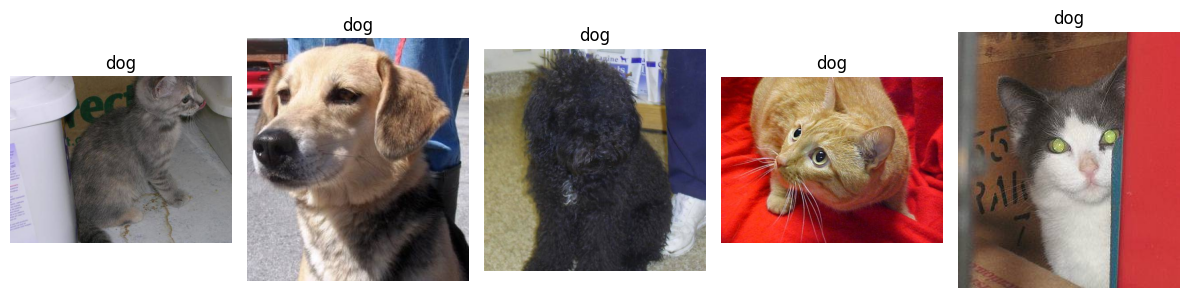

In [48]:
# 6-89 모델 예측에 대한 결과 출력
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]

        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
display_image_grid(test_images_filepaths)

ResNet 모델의 예측 결과
- 정확도 높지 않음
- 성능을 향상시키려면 데이터를 더 늘려야 함